In [3]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import figure, draw, pause
import matplotlib.colors
from IPython.display import clear_output
from sklearn.preprocessing import normalize

import copy



In [4]:
def random_forest(width, height, vegetation_ratio=0.5):
    map_matrix = np.zeros((height, width))
    
    water = 0
    land = 1
    vegetation = 2
    
    for i in range(height):
        for j in range(width):
            
            # 2 tiles water padding
            if i < 2 or i > height - 3 or j < 2 or j > width - 3:
                map_matrix[i][j] = water

            # set initial vegetation
            elif random.random() < vegetation_ratio:
                map_matrix[i][j] = vegetation
            
            # set land
            else:
                map_matrix[i][j] = land
                
    return map_matrix


def wind_matrix(degrees, multiplier=1):
    
    if multiplier < 0 or multiplier > 2:
        raise Exception('Please select a multiplier between 0 and 2 (inclusive).')

    degrees = degrees % 360
    
    north_diff = min(abs(360 - degrees), abs(360 - (degrees + 360))) / 180
    south_diff = min(abs(180 - degrees), abs(180 - (degrees + 360))) / 180
    west_diff = min(abs(270 - degrees), abs(270 - (degrees + 360))) / 180
    east_diff = min(abs(90 - degrees), abs(90 - (degrees + 360))) / 180
    
    wind_matrix = np.zeros((3,3))
    wind_matrix[1, 1] = 1
    
    wind_matrix[0, 1] = 1 + (north_diff - .5) * multiplier
    wind_matrix[2, 1] = 1 + (south_diff - .5) * multiplier
    wind_matrix[1, 0] = 1 + (west_diff - .5) * multiplier
    wind_matrix[1, 2] = 1 + (east_diff - .5) * multiplier
    
    wind_matrix[0, 0] = np.mean([wind_matrix[0, 1], wind_matrix[1, 0]])
    wind_matrix[0, 2] = np.mean([wind_matrix[0, 1], wind_matrix[1, 2]])
    wind_matrix[2, 0] = np.mean([wind_matrix[1, 0], wind_matrix[2, 1]])
    wind_matrix[2, 2] = np.mean([wind_matrix[2, 1], wind_matrix[1, 2]])
    
    return wind_matrix / (np.ones((3, 3)) * np.max(wind_matrix))

In [12]:
class ForestFires:
    def __init__(self, map_matrix, init_burning_ratio, init_ratio_burned, wind_dir=0, wind_speed=0):
        self.map_matrix = map_matrix
        self.init_burning_ratio = init_burning_ratio
        self.init_ratio_burned = init_ratio_burned
        
        self.neigh_dirs = [[-1,-1], [-1,0], [-1,1], [0,-1], [0,0], [0,1], [1,-1], [1,0], [1,1]]
        
        self.neigh_mult = np.array([[.833, 1, .833], [1, 1, 1], [.833, 1, .833]])
        self.veg_population = self.set_vegetation_population(self.map_matrix)
        
        self.wind_matrix = wind_matrix(wind_dir, wind_speed)  
#         print(self.wind_matrix)
            
        
    def set_vegetation_population(self, map_matrix):
        veg_population = {}
        
        # iterate over grid
        for y in range(len(map_matrix)):
            for x in range(len(map_matrix[0])):
                
                # if vegetation
                if map_matrix[y, x] == 2:
                    
                    # initial propability of vegetation burning
                    if random.random() < self.init_burning_ratio:
                        veg_population[(x,y)] = Vegetation(self.init_ratio_burned, 1)
                        
                    else:
                        veg_population[(x,y)] = Vegetation(0, 1)
                    
        return veg_population
                    
    
        
    def update(self):
        
#         current_veg_pop = copy.deepcopy(self.veg_population)
        temp_dict = {}

        for (x,y) in self.veg_population:
            if self.veg_population[(x,y)].ratio_burned != 1:    
                neigh_matrix = np.zeros((3,3))

                for (y_2, x_2) in self.neigh_dirs:
                    neigh_y = y + y_2
                    neigh_x = x + x_2

                    if self.map_matrix[neigh_y, neigh_x] == 2:
                        neigh_matrix[y_2 + 1, x_2 + 1] = self.veg_population[(neigh_x, neigh_y)].ratio_burned

                
                kernel = neigh_matrix * self.neigh_mult * self.wind_matrix
#                 kernel = neigh_matrix * self.neigh_mult
    
                kernel[kernel < np.random.rand(3,3)] = 0

                summed_matrix = np.sum(kernel) 

#                 current_veg_pop[(x,y)].ratio_burned = (summed_matrix if summed_matrix < 1 else 1)
                
                temp_dict[(x,y)] = Vegetation((summed_matrix if summed_matrix < 1 else 1), 1)
                
        for (x, y) in temp_dict:
            self.veg_population[(x,y)] = temp_dict[(x,y)]
#         self.veg_population = current_veg_pop.copy()
#         self.veg_population = current_veg_pop
                
        
    def visualize(self):
        current_map = self.map_matrix.copy()
#         current_map = copy.deepcopy(self.map_matrix)
        
        fire_gradations = []
        
        for (x,y) in self.veg_population:
            p_burned = self.veg_population[(x,y)].ratio_burned
            if p_burned > 0:
                # start stage of fire
                if p_burned <= 0.33:
                    current_map[y][x] = 6
                    if 'yellow' not in fire_gradations:
                        fire_gradations.append('yellow')
                    
                # middle stage of fire
                elif p_burned > 0.33 and p_burned <= 0.66:
                    current_map[y][x] = 4
                    if 'orange' not in fire_gradations:
                        fire_gradations.append('orange')
                    
                # last stage of fire
                elif p_burned > 0.66 and p_burned < 1:
                    current_map[y][x] = 5
                    if 'red' not in fire_gradations:
                        fire_gradations.append('red')
                    
                # burned up
                else:
                    current_map[y][x] = 3
                    if 'black' not in fire_gradations:
                        fire_gradations.append('black')
                        
        colors = ['blue', 'lightgrey', 'green']
        if fire_gradations:
            fire_gradations = sorted(fire_gradations)
            colors += fire_gradations    
        
        figure(num=None, figsize=(10, 10))
        plt.imshow(current_map, cmap=matplotlib.colors.ListedColormap(colors))
        plt.show()
        clear_output(wait=True)
    
        
class Vegetation:
    def __init__(self, ratio_burned, height):
    
        # burning or neutral
        self.ratio_burned = ratio_burned
        self.height = height

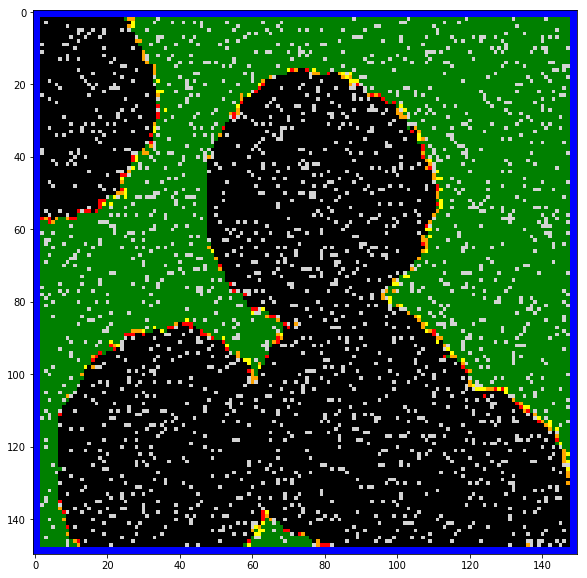

In [13]:
map_array = random_forest(150, 150, vegetation_ratio=0.9)
forest_sim = ForestFires(map_array, init_burning_ratio=0.001, init_ratio_burned=0.5, wind_dir=270, wind_speed=1)
# forest_sim.visualize()
iterations = 50

for i in range(iterations):
    forest_sim.visualize()
    forest_sim.update()

